In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import imageio
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
#importing data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_directory = "/content/drive/MyDrive/car_data"
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")
image_size = (128, 128)

In [ ]:
# Function to load and preprocess data
def load_and_preprocess_data(directory, image_size):
    data = []
    labels = []
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)
        label = category

        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize
            data.append(image_array)
            labels.append(label)
    return np.array(data), np.array(labels)

In [ ]:
# Load Train and Test data
X_train, train_labels = load_and_preprocess_data(train_directory, image_size)
X_valid, valid_labels = load_and_preprocess_data(test_directory, image_size)

In [ ]:
#save in drive for later use
np.save('/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning/train_labels.npy', train_labels)
np.save('/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning/X_valid.npy', X_valid)
np.save('/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning/valid_labels.npy', valid_labels)

In [4]:
X_train = np.load('/content/drive/MyDrive/X_train.npy')
train_labels = np.load('/content/drive/MyDrive/train_labels.npy')
X_valid = np.load('/content/drive/MyDrive/X_valid.npy')
valid_labels = np.load('/content/drive/MyDrive/valid_labels.npy')

In [5]:
# 4. Encode string labels → integer indices → one‐hot vectors
le = LabelEncoder()
le.fit(np.concatenate([train_labels, valid_labels]))
y_train_int = le.transform(train_labels)
y_valid_int = le.transform(valid_labels)

num_classes = len(le.classes_)
print("Classes found:", le.classes_, "→ num_classes =", num_classes)

y_train = to_categorical(y_train_int, num_classes=num_classes)
y_valid = to_categorical(y_valid_int, num_classes=num_classes)

print("y_train shape:", y_train.shape)  # (num_train_samples, num_classes)
print("y_valid shape:", y_valid.shape)  # (num_valid_samples, num_classes)


Classes found: ['AM General Hummer SUV 2000' 'Acura Integra Type R 2001'
 'Acura RL Sedan 2012' 'Acura TL Sedan 2012' 'Acura TL Type-S 2008'
 'Acura TSX Sedan 2012' 'Acura ZDX Hatchback 2012'
 'Aston Martin V8 Vantage Convertible 2012'
 'Aston Martin V8 Vantage Coupe 2012'
 'Aston Martin Virage Convertible 2012' 'Aston Martin Virage Coupe 2012'
 'Audi 100 Sedan 1994' 'Audi 100 Wagon 1994' 'Audi A5 Coupe 2012'
 'Audi R8 Coupe 2012' 'Audi RS 4 Convertible 2008' 'Audi S4 Sedan 2007'
 'Audi S4 Sedan 2012' 'Audi S5 Convertible 2012' 'Audi S5 Coupe 2012'
 'Audi S6 Sedan 2011' 'Audi TT Hatchback 2011' 'Audi TT RS Coupe 2012'
 'Audi TTS Coupe 2012' 'Audi V8 Sedan 1994'
 'BMW 1 Series Convertible 2012' 'BMW 1 Series Coupe 2012'
 'BMW 3 Series Sedan 2012' 'BMW 3 Series Wagon 2012'
 'BMW 6 Series Convertible 2007' 'BMW ActiveHybrid 5 Sedan 2012'
 'BMW M3 Coupe 2012' 'BMW M5 Sedan 2010' 'BMW M6 Convertible 2010'
 'BMW X3 SUV 2012' 'BMW X5 SUV 2007' 'BMW X6 SUV 2012'
 'BMW Z4 Convertible 2012' 'Ben

In [6]:
#4. making a cnn model

weight_decay = 1e-4

model = models.Sequential([
    # Input layer
    layers.InputLayer(input_shape=(image_size[0], image_size[1], 3)),

    # Block 1: 32 filters
    layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.25),

    # Block 2: 64 filters
    layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.25),

    # Block 3: 128 filters
    layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.25),

    # Block 4: 256 filters
    layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.25),

    # Block 5: 512 filters
    layers.Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.25),

    # Block 6 (NEW): 512 filters
    layers.Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.25),

    # Classification head
    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             

 Total params: 11,747,044 (44.81 MB)

 Trainable params: 11,738,980 (44.78 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,                  # stop after 10 epochs of no improvement
    mode='min',
    verbose=1,
    restore_best_weights=True     # revert to model weights from best epoch
)

In [8]:
# 5. Train the model

BATCH_SIZE   = 32
EPOCHS       = 70
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    shuffle=True,
    callbacks=[early_stop]
)

Epoch 1/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 86s 152ms/step - accuracy: 0.0069 - loss: 6.2881 - val_accuracy: 0.0056 - val_loss: 5.7369
Epoch 2/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.0083 - loss: 5.9104 - val_accuracy: 0.0063 - val_loss: 5.7047
Epoch 3/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.0105 - loss: 5.8772 - val_accuracy: 0.0070 - val_loss: 5.7589
Epoch 4/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.0135 - loss: 5.8151 - val_accuracy: 0.0094 - val_loss: 5.8468
Epoch 5/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.0150 - loss: 5.7481 - val_accuracy: 0.0087 - val_loss: 5.7733
Epoch 6/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.0136 - loss: 5.6793 - val_accuracy: 0.0157 - val_loss: 5.8130
Epoch 7/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.0185 - loss: 5.5847 - val_accuracy: 0.0140 - val_loss: 5.6622
Epoch 8/70
378/378 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.0292 - loss: 5.4766 -

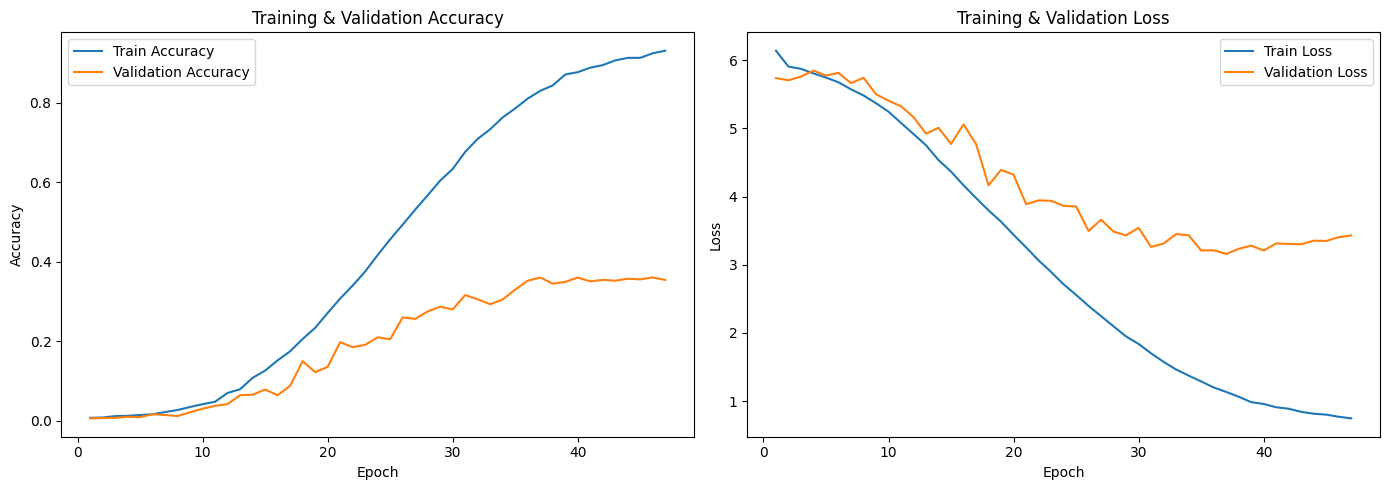

In [10]:
# 7. Plot training & validation accuracy/loss vs. epochs
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1) # Adjusted to match the actual number of epochs

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,      label='Train Accuracy')
plt.plot(epochs_range, val_acc,  label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,     label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def display_test_predictions(model, X, y_true_int, label_encoder, num_images=9):
    """
    Displays a grid of test images along with their true and predicted labels.

    
    """
    assert num_images <= len(X), "num_images cannot exceed the size of X"

    # Pick random indices without replacement
    indices = random.sample(range(len(X)), num_images)

    # Compute predictions for the selected images
    X_subset = X[indices]
    preds = model.predict(X_subset)  # shape: (num_images, num_classes)
    pred_ints = preds.argmax(axis=1)  # integer-predicted labels

    # Map integer labels back to class names
    class_names = label_encoder.classes_
    y_true_names = class_names[y_true_int[indices]]
    y_pred_names = class_names[pred_ints]

    # Determine grid size from num_images (e.g., 9 → 3×3, 4 → 2×2, 16 → 4×4)
    grid_size = int(num_images ** 0.5)

    plt.figure(figsize=(grid_size * 3, grid_size * 3))
    for i, idx in enumerate(indices):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(X[idx])
        plt.axis('off')

        title_color = 'green' if y_pred_names[i] == y_true_names[i] else 'red'
        ax.set_title(f"True: {y_true_names[i]}\nPred: {y_pred_names[i]}", color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


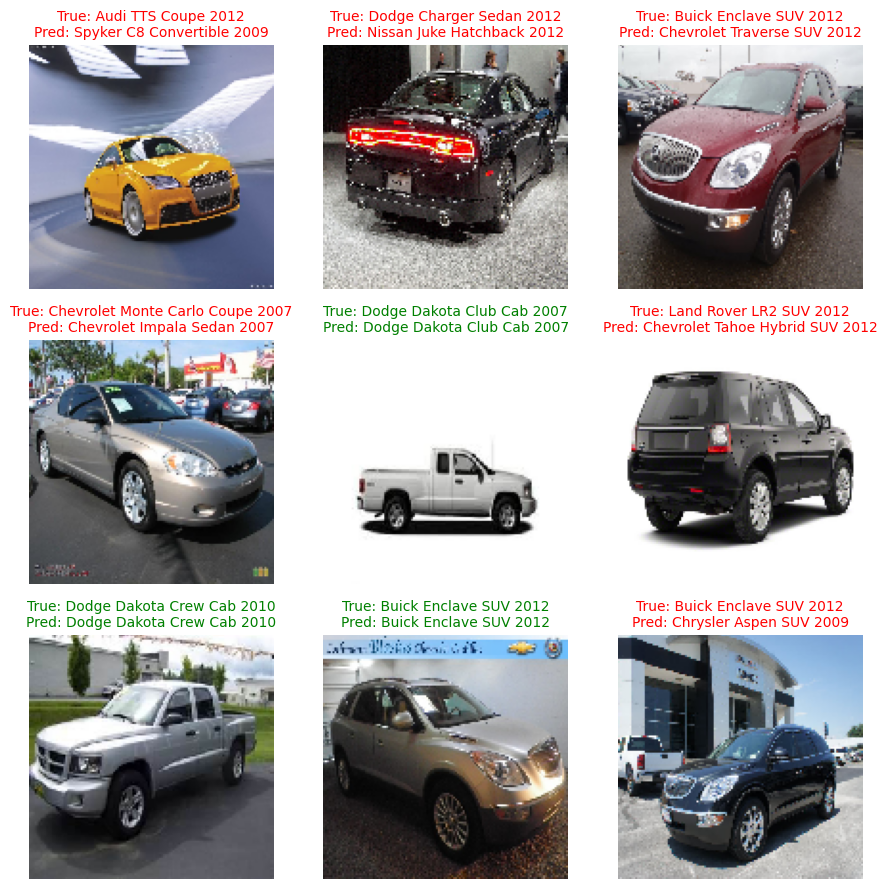

In [15]:
display_test_predictions(model, X_valid, y_valid_int, le, num_images=9)

In [13]:
import os
from tensorflow.keras.models import load_model
from google.colab import files

save_dir = "/content/drive/MyDrive/Colab Notebooks"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "cnn_model2.keras")
model.save(model_path)